In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon, Point, box
import re
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

%cd ..

c:\Users\javie\Documents\magister\propagacion-incendios


C:\Users\javie\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
carpeta = "data/procesado/satellite_data/suomi"
archivos = [f.name for f in Path(carpeta).iterdir() if f.is_file()]
regex = re.compile(r"A\d{7}\.\d{4}\.\d{3}") 

In [3]:
path_areas = Path('data/procesado/zonas_incendios/areas_buffer.geojson')
areas = gpd.read_file(path_areas)

### functions

In [4]:
def extraer_fecha(cadena):
    año = int(cadena[1:5])
    dia_juliano = int(cadena[5:8])
    hora = int(cadena[9:11])
    minuto = int(cadena[11:13])
    
    fecha = datetime(año, 1, 1) + timedelta(days=dia_juliano - 1)
    fecha = fecha.replace(hour=hora, minute=minuto)
    return fecha

def make_pixel_square(point, size=375):
    half = size / 2
    return box(point.x - half, point.y - half, point.x + half, point.y + half)


### rev data

In [5]:
## path data
carpeta = "data/procesado/satellite_data/suomi"
archivos = [f.name for f in Path(carpeta).iterdir() if f.is_file()]
regex = re.compile(r"A\d{7}\.\d{4}\.\d{3}") 

In [6]:
## load
gdf_zonas = []
for id in range(len(archivos)):
    
    arch = archivos[id]
    print(arch)
    fecha = regex.search(str(arch)).group()
    data = gpd.read_file(carpeta + '/' + arch)
    data['date_time'] = extraer_fecha(fecha)
    data['date_file'] = fecha
    
    gdf_zonas.append(data)

gdf_zonas = gpd.GeoDataFrame(pd.concat(gdf_zonas, ignore_index=True), crs=gdf_zonas[0].crs) 


merge_A2025102.0818.002.geojson
merge_A2025102.1942.002.geojson
merge_A2025103.0800.002.geojson
merge_A2025103.1924.002.geojson
merge_A2025105.0724.002.geojson
merge_A2025105.0900.002.geojson
merge_A2025105.1842.002.geojson
merge_A2025105.2024.002.geojson
merge_A2025106.0706.002.geojson
merge_A2025106.0842.002.geojson
merge_A2025106.1824.002.geojson
merge_A2025106.2006.002.geojson


In [49]:
#gdf_zonas2 = gdf_zonas[gdf_zonas['I02_uncert_index'].isna()]
aux = gdf_zonas[gdf_zonas.eval('zona == "bee_rock_creek"')]

In [50]:
aux.date_time.value_counts()

date_time
2025-04-13 08:00:00    449
2025-04-16 18:24:00    381
2025-04-15 07:24:00    373
2025-04-16 07:06:00    356
2025-04-15 18:42:00    323
2025-04-12 08:18:00    211
Name: count, dtype: int64

In [ ]:
# momento1 = aux[aux['date_time'] == '2025-04-15 07:24:00']
# momento2 = aux[aux['date_time'] == '2025-04-15 18:42:00']
# momento3 =  aux[aux['date_time'] == '2025-04-16 07:06:00']
# momento4 =  aux[aux['date_time'] == '2025-04-16 07:06:00']

In [51]:
## para plotear -> buffer 375
gdf_m = aux.to_crs("EPSG:5070") 

gdf_m['geometry'] = gdf_m.geometry.apply(lambda p: make_pixel_square(p, size=375))

gdf_pixel_polys = gdf_m.to_crs("EPSG:4326")


### healphix

In [10]:
from rhealpixdggs.dggs import *
from shapely.geometry import Polygon

rdggs = RHEALPixDGGS()

In [11]:
geom = areas[areas['zona'] == 'bee_rock_creek']['geometry'].iloc[0]

nw = (geom.bounds[0], geom.bounds[3])
se = (geom.bounds[2], geom.bounds[1])
Nivel = 10

polygons = []
codigo = []
cells = rdggs.cells_from_region(Nivel, nw, se, plane=False)
for row in cells:
    for cell in row:
        coordenadas = []
        celda = str(cell)
        primero = [celda[0]]+ [int(c) for c in celda[1:]]
        c = rdggs.cell(primero)
        for d in c.boundary(n=2, plane=False):
            # coord = tuple(my_round(val, 14) for val in d)
            coord = tuple(round(val, 14) for val in d)            
            coordenadas.append(coord)
        if coordenadas[0] != coordenadas[-1]:
            coordenadas.append(coordenadas[0])
        codigo.append(celda)
        polygon = Polygon(coordenadas)
        polygons.append(polygon)

gdf_healpix = gpd.GeoDataFrame(crs="EPSG:4326", geometry=polygons)
gdf_healpix['Codigo'] = codigo

In [ ]:
gdf_pixel_polys1 = gdf_pixel_polys[gdf_pixel_polys['date_time'] == '2025-04-15 07:24:00']
gdf_pixel_polys2 = gdf_pixel_polys[gdf_pixel_polys['date_time'] == '2025-04-15 18:42:00']

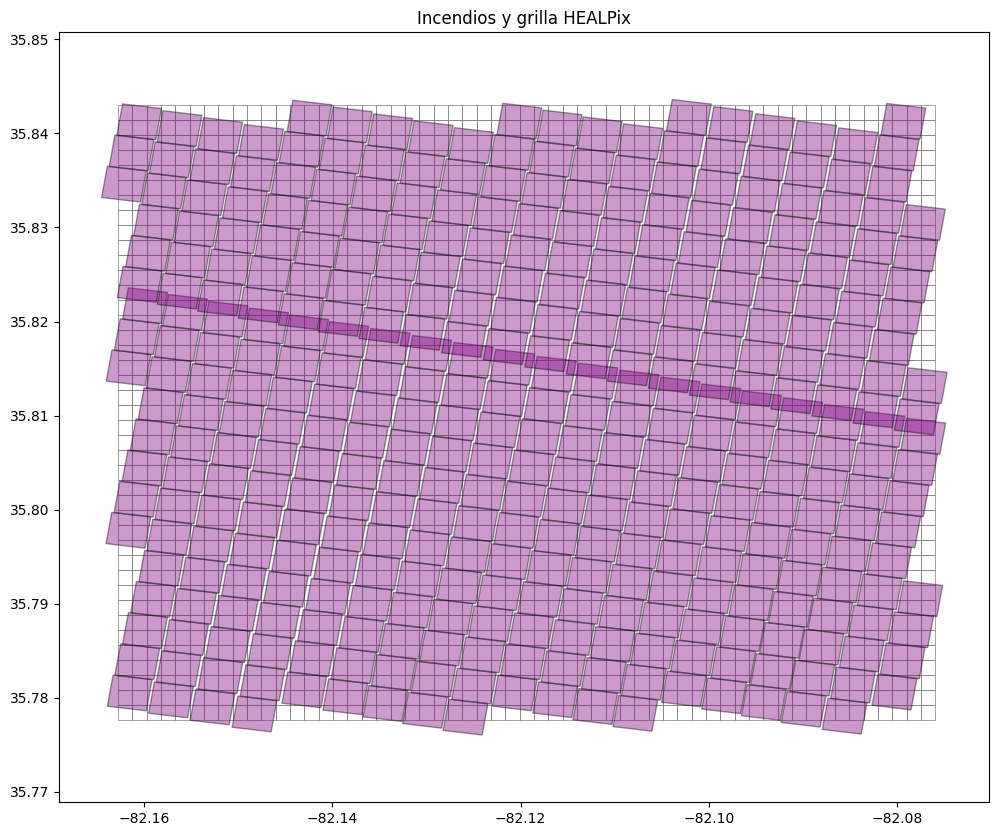

In [56]:
fig, ax = plt.subplots(figsize=(12, 10))

# grilla de fondo
gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5, label='Grilla HEALPix')

# pixeles de incendio
gdf_pixel_polys1.plot(ax=ax, color= 'purple',edgecolor='black', alpha=0.4, legend=True)
#gdf_pixel_polys2.plot(ax=ax, color= 'red', cmap= 'viridis',edgecolor='black', alpha=0.4, legend=True)

ax.set_title("Incendios y grilla HEALPix")
plt.axis('equal')
plt.show()

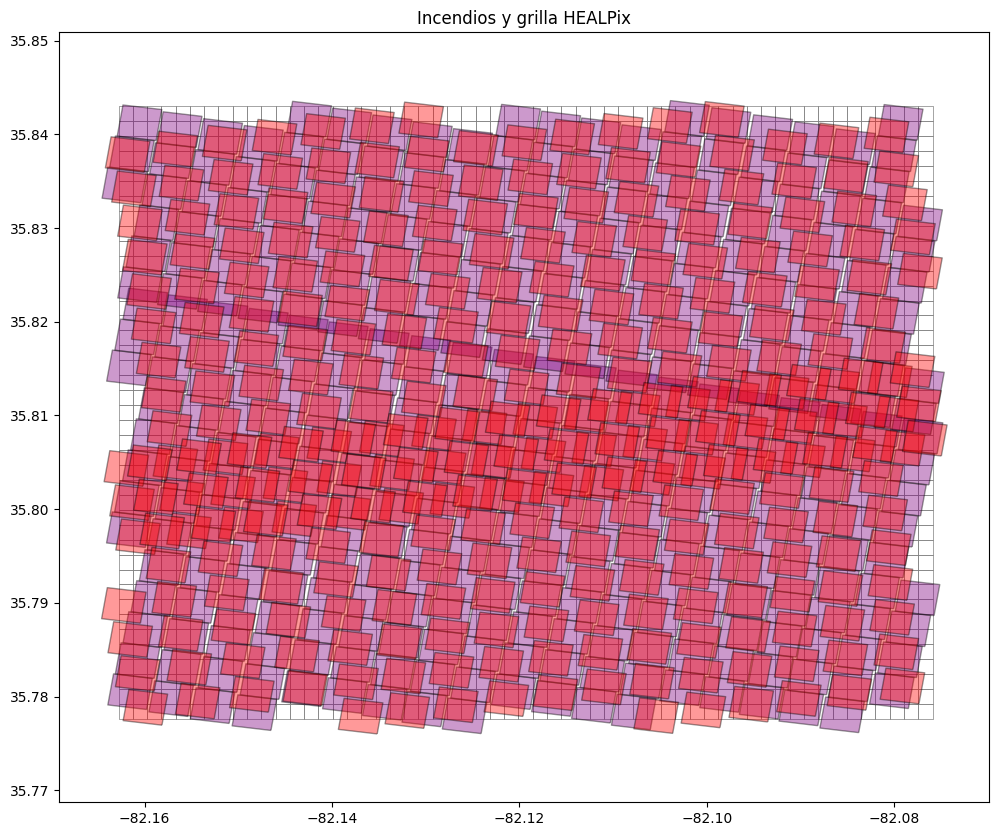

In [57]:
fig, ax = plt.subplots(figsize=(12, 10))

# grilla de fondo
gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5, label='Grilla HEALPix')

# pixeles de incendio
gdf_pixel_polys1.plot(ax=ax, color= 'purple',edgecolor='black', alpha=0.4, legend=True)
gdf_pixel_polys2.plot(ax=ax, color= 'red',edgecolor='black', alpha=0.4, legend=True)

ax.set_title("Incendios y grilla HEALPix")
plt.axis('equal')
plt.show()

In [28]:
from matplotlib.colors import Normalize

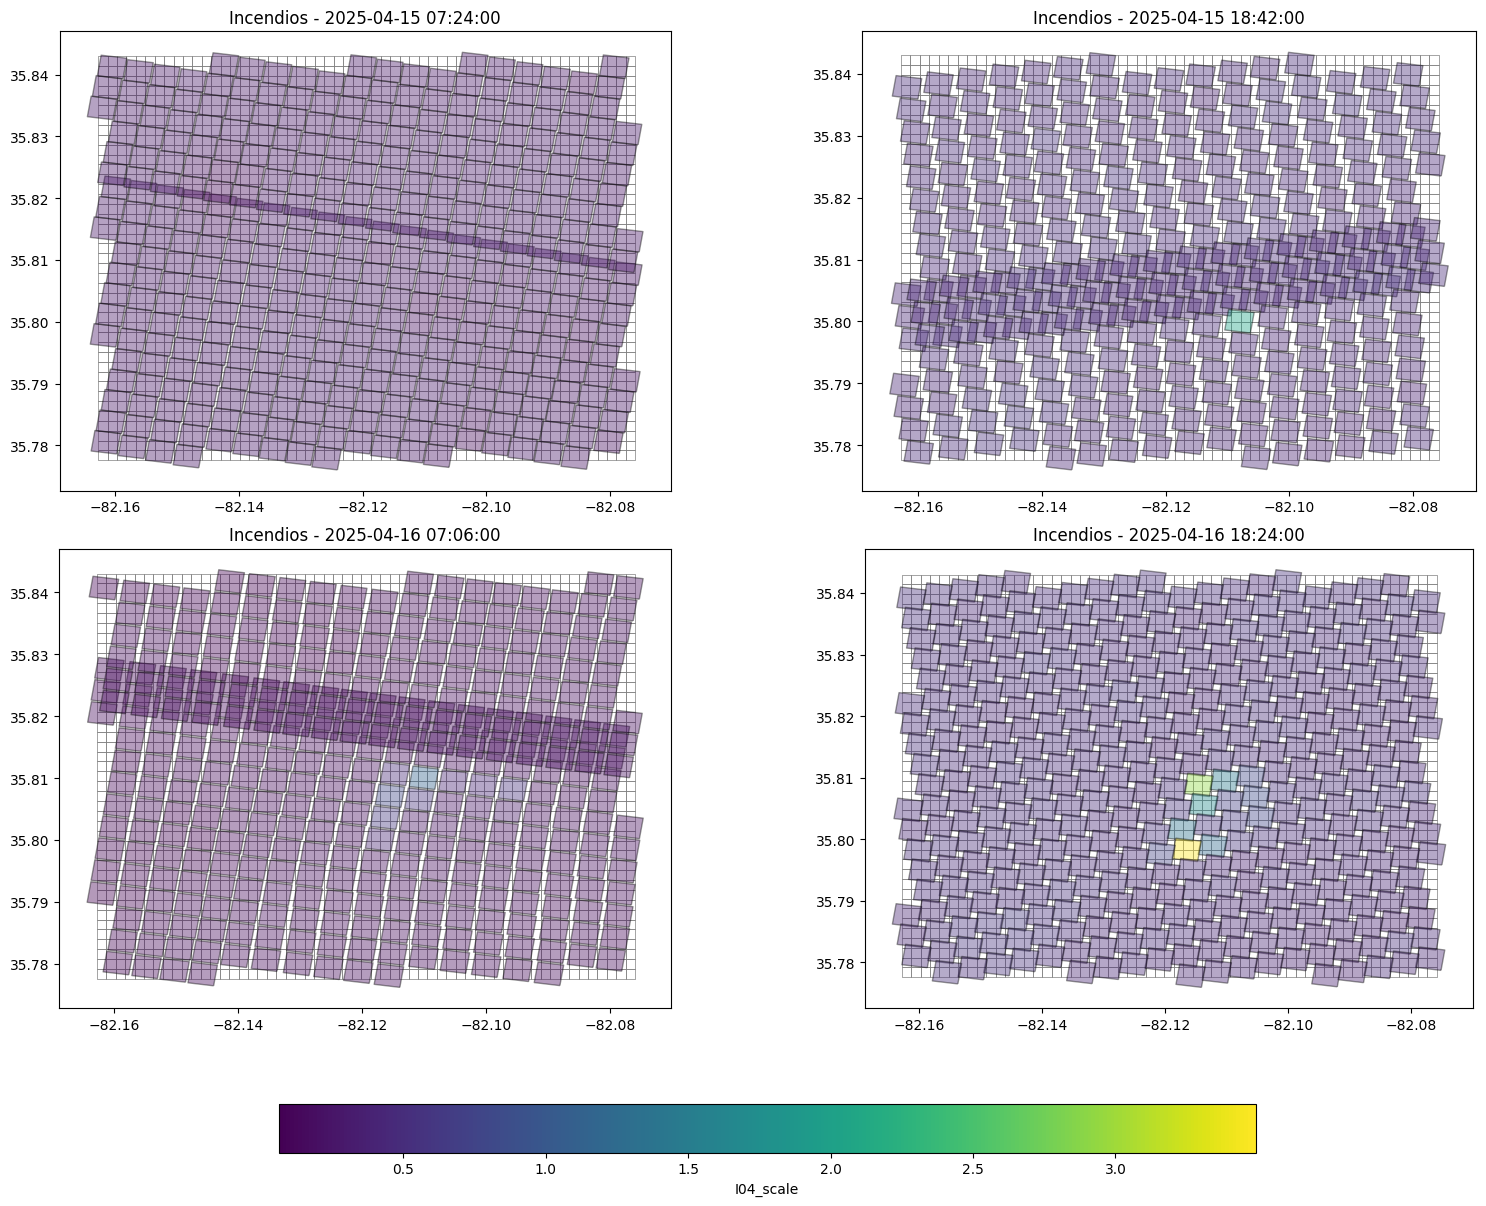

In [ ]:
gdf_pixel_polys3 = gdf_pixel_polys[gdf_pixel_polys['date_time'] == '2025-04-16 07:06:00']
gdf_pixel_polys4 = gdf_pixel_polys[gdf_pixel_polys['date_time'] == '2025-04-16 18:24:00']

gdfs = [gdf_pixel_polys1, gdf_pixel_polys2, gdf_pixel_polys3, gdf_pixel_polys4]

# Calcular el rango común 
vmin = min(gdf["I04_scale"].min() for gdf in gdfs)
vmax = max(gdf["I04_scale"].max() for gdf in gdfs)
norm = Normalize(vmin=vmin, vmax=vmax)


fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)
axes = axes.flatten()  

for i, gdf in enumerate(gdfs):
    ax = axes[i]
    gdf_healpix.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)
    gdf.plot(ax=ax, column="I04_scale", cmap='viridis', edgecolor='black', alpha=0.4, norm=norm)
    ax.set_title(f"Incendios - {str(gdf['date_time'].iloc[0])}")
    ax.set_aspect("equal")


sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.07, label="I04_scale")

plt.show()
